# Bag of Words Meets Bags of Popcorn
## Use Google's Word2Vec for movie reviews

URL: https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import clear_output
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## First look on data

In [2]:
data = pd.read_csv("./data/labeledTrainData.tsv.zip", delimiter="\t")

In [3]:
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [5]:
data.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [6]:
data.nunique()

id           25000
sentiment        2
review       24904
dtype: int64

In [7]:
data.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

Distribution of classes

<AxesSubplot:xlabel='sentiment', ylabel='count'>

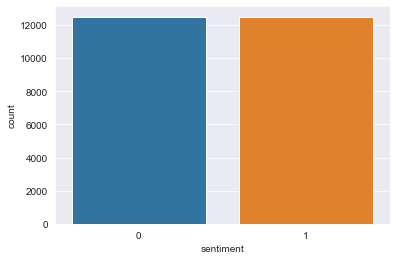

In [8]:
sns.countplot(data["sentiment"])

Length of sentences and word number distributions

<AxesSubplot:xlabel='word count', ylabel='Density'>

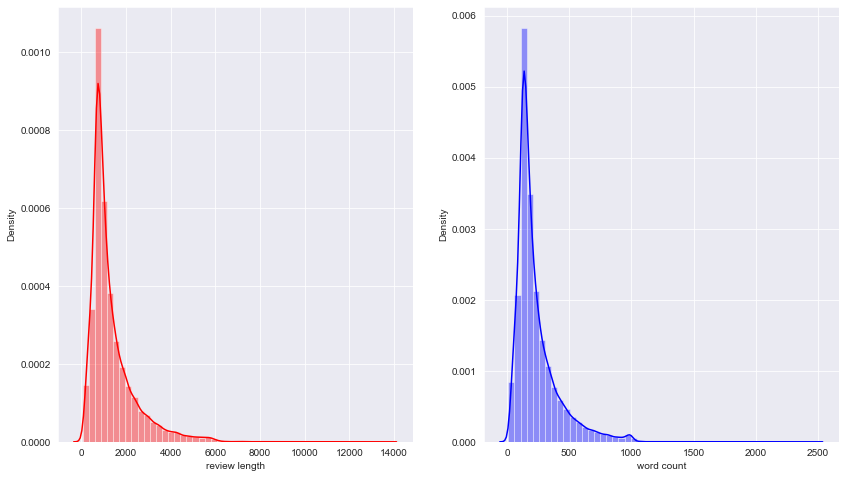

In [9]:
sentences_length = data["review"].apply(len).rename("review length")
word_count = data["review"].apply(lambda row: len(str(row).split(" "))).rename("word count")

fig=plt.figure(figsize=(14,8))
fig.add_subplot(1, 2, 1)
sns.distplot(sentences_length,color='red')
fig.add_subplot(1, 2, 2)
sns.distplot(word_count,color='blue')

In [10]:
sentences_length.describe()

count    25000.000000
mean      1327.710560
std       1005.239246
min         52.000000
25%        703.000000
50%        981.000000
75%       1617.000000
max      13708.000000
Name: review length, dtype: float64

In [11]:
word_count.describe()

count    25000.000000
mean       233.786240
std        173.745845
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: word count, dtype: float64

Word cloud of uncleaned data

(-0.5, 799.5, 599.5, -0.5)

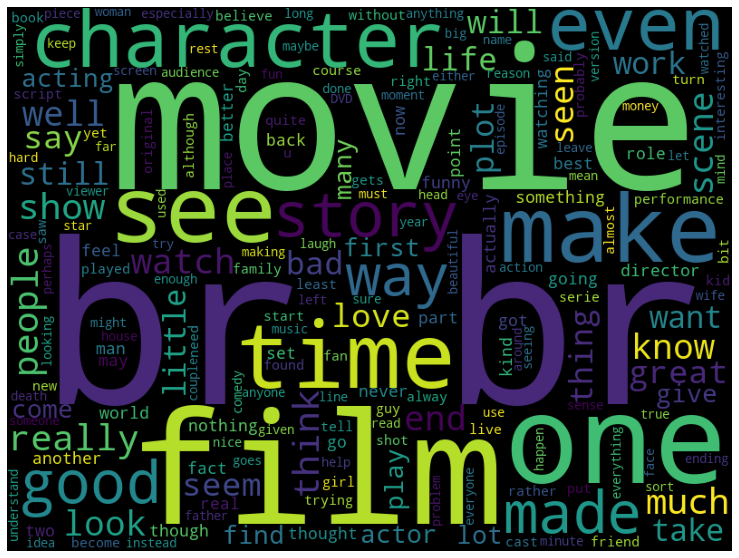

In [12]:
cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(" ".join(data["review"]))
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

## Cleaning data

In [13]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords


stop_words=set(stopwords.words('english'))

In [14]:
def clean_data(string: str) -> str:
    # delete HTML-tags
    text = BeautifulSoup(string, "lxml").get_text()
    # delete no text data
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    # process into lower case
    lowercase_text = letters_only.lower()
    # delete stop-words
    no_stop_words = [word for word in lowercase_text.split() if word not in stop_words]
    return " ".join(no_stop_words)

In [15]:
cleaned_data = data.copy()
cleaned_data["review"] = cleaned_data["review"].apply(clean_data)

In [16]:
cleaned_data.head()

,id,sentiment,review
0,5814_8,1,stuff going moment mj started listening music ...
1,2381_9,1,classic war worlds timothy hines entertaining ...
2,7759_3,0,film starts manager nicholas bell giving welco...
3,3630_4,0,must assumed praised film greatest filmed oper...
4,9495_8,1,superbly trashy wondrously unpretentious explo...


(-0.5, 799.5, 599.5, -0.5)

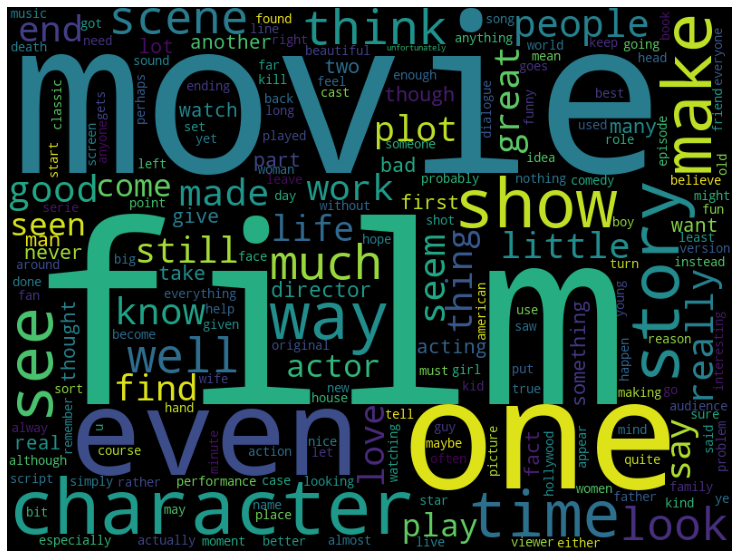

In [17]:
cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(" ".join(cleaned_data["review"]))
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

## Deep text processing with lemmatization

In [18]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm
clear_output()

In [19]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [20]:
cleaned_data["review"].apply(len).max() < nlp.max_length

True

Example

In [21]:
print("Original text:")
print(cleaned_data.iloc[0]["review"])
print("=" * 40)
print("Text after lemmatization:")
doc = nlp(cleaned_data.iloc[0]["review"])
print(" ".join([token.lemma_ for token in doc]))

Original text:
stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directo

In [22]:
def text_lemmatization(row: str) -> str:
    doc = nlp(row)
    return " ".join([token.lemma_ for token in doc])

In [23]:
lemmatization_data = cleaned_data.copy()
lemmatization_data["review"] = lemmatization_data["review"].apply(text_lemmatization)

In [24]:
lemmatization_data.head()

,id,sentiment,review
0,5814_8,1,stuff go moment mj start listen music watch od...
1,2381_9,1,classic war world timothy hine entertain film ...
2,7759_3,0,film start manager nicholas bell give welcome ...
3,3630_4,0,must assume praise film greatest film opera ev...
4,9495_8,1,superbly trashy wondrously unpretentious explo...


## Create word vectors

In [25]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from nltk.tokenize import TreebankWordTokenizer

In [26]:
sentences = []
tokenizer = TreebankWordTokenizer()

for review in tqdm(lemmatization_data["review"].to_list()):
    sentence = []
    raw_sentences = tokenizer.tokenize(str(review).rstrip())
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentence.append(raw_sentence)
    sentences.append(sentence)

100%|██████████| 25000/25000 [00:06<00:00, 3995.43it/s]


In [27]:
print(len(sentences))

25000


In [28]:
%%time
word_2_vec_model = Word2Vec(vector_size=100, window=5, min_count=1, workers=cpu_count())
word_2_vec_model.build_vocab(sentences)
word_2_vec_model.train(sentences, total_examples=word_2_vec_model.corpus_count, epochs=20)

CPU times: total: 2min 8s
Wall time: 20.1 s


(55821725, 59818900)

In [29]:
word_2_vec_model.save("word_2_vec_model")

In [30]:
word_2_vec_model = Word2Vec.load("word_2_vec_model")

In [31]:
def tokenize_and_vectorize_text(rows: list) -> list:
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    for sample in tqdm(rows):
        tokens = tokenizer.tokenize(sample)
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_2_vec_model.wv[token])
            except KeyError:
                pass
        vectorized_data.append(sample_vecs)
    return vectorized_data

In [32]:
vectorize_data = tokenize_and_vectorize_text(lemmatization_data["review"].to_list())
labels = lemmatization_data["sentiment"].to_list()

100%|██████████| 25000/25000 [00:09<00:00, 2744.81it/s]


In [33]:
print(len(vectorize_data))
print(len(labels))

25000
25000


## Validate model

### CatBoost

### Neural Network